In [413]:
import numpy as np
import seaborn as sns
from functools import partial

## SGHMC

In [284]:
def hmc_1d(theta0,grad,M,C,epsilon,iter=1000):
    """
    This function outputs the 1 dimiension Hamilton Monte Carlo samples without M-H correction.
    
    Args: 
        theta0: the initial point of theta, the parameter of interest
        grad: the gradient of the potential
        M: the mass
        C: the C term, where C*M^{-1} is the friction
        epsilon: stepsize
        iter: iteration number, 1000 by default
    """
    r=np.random.normal(0,np.sqrt(M))
    theta=theta0
    theta_save=np.zeros(iter)
    r_save=np.zeros(iter)
    for t in range(iter):
        theta=theta+epsilon*r/M
        r=r-grad(theta)*epsilon-epsilon*C*r/M+np.random.normal(0,np.sqrt(2*epsilon*C))
        theta_save[t]=theta
        r_save[t]=r
    return theta_save,r_save

/opt/conda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


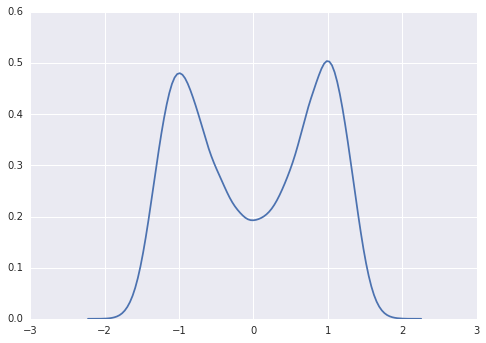

In [287]:
#####Rerun the example in Figure 1#####
theta0=0
M=1
C=1
grad=lambda theta: -4*theta+4*theta**3
epsilon=.1
iter=1000
theta_save,r_save=hmc_1d(theta0,grad,M,C,epsilon,iter=300000)
sns.kdeplot(theta_save)
pass

In [300]:
def hmc(theta0,grad,M,C,epsilon,p,iter=1000):
    """
    This function outputs the p dimiension Hamilton Monte Carlo samples without M-H correction.    
    Args: 
        theta0: the initial point of theta, the parameter of interest
        grad: the gradient of the potential
        M: the mass
        C: the C term, where C*M^{-1} is the friction
        epsilon: stepsize
        p: the dimension of theta
        iter: iteration number, 1000 by default
    """
    r=np.random.multivariate_normal(np.zeros(p),M).reshape(p,1)
    theta=theta0
    theta_save=np.zeros([p,iter])
    r_save=np.zeros([p,iter])
    for t in range(iter):    
        theta=theta+epsilon*(np.linalg.inv(M) @ r)
        r=r-grad(theta)*epsilon-epsilon*(C @ np.linalg.inv(M) @ r)+np.random.multivariate_normal(np.zeros(p),2*epsilon*C,1).T
        theta_save[:,t]=theta.ravel()
        r_save[:,t]=r.ravel()
    return theta_save,r_save

In [301]:
###Rerun the example in Figure 3
theta0=np.zeros(2).reshape([2,1])
M=np.array([[1,0],[0,1]])
C=np.array([[1,0],[0,1]])
grad=lambda theta:  np.linalg.inv(np.array([[1,.9],[.9,1]])) @ theta
epsilon=.1
iter=30000
theta_save, r_save=hmc(theta0,grad,M,C,epsilon,2,iter=30000)

In [302]:
np.corrcoef(theta_save[0,:],theta_save[1,:])

array([[ 1.        ,  0.90222882],
       [ 0.90222882,  1.        ]])

In [ ]:
####Logistics Regression

In [414]:
###simulate data
def sim_log(m,n,theta):
    """This function outputs a simulated logistics regression dataset X and y. 
       X is a matrix of size m by n. Every entry of X is i.i.d N(0,1).
    Args:
        m: the number of rows in X
        n: the number of columns in X
        beta: a n by 1 vector, the true beta in the model
    """
    X=np.random.normal(loc=0,scale=1,size=[m,n])
    y=np.random.binomial(n=1,p=1/(1+np.exp(-(X @ theta))))
    return X,y

In [415]:
def grad_est_logit(theta,size,X,y):
    """Return the noisy estimated gradient at theta by a size S uniform subsample.
    Args:
        size: the subsample size
        X,y: the dataset
    """
    T=X.shape[0]
    p=X.shape[1]
    indice=np.random.choice(np.arange(T),size,replace=False)
    return -(np.diagflat((y[indice]-1/(1+np.exp(-X[indice,:] @ theta)))) @ X[indice,:]).mean(0).reshape([p,1])*T

In [416]:
theta=np.array([10,20,-10,0,0]).reshape([5,1])
X,y=sim_log(20000,5,theta)

In [410]:
def sghmc_logit(X,y,theta0,M,C,epsilon,size,iter=1000):
    p=X.shape[1]
    T=X.shape[0]
    r=np.random.multivariate_normal(np.zeros(p),M).reshape(p,1)
    theta=theta0
    theta_save=np.zeros([p,iter])
    r_save=np.zeros([p,iter])
    for t in range(iter):    
        theta=theta+epsilon*(np.linalg.inv(M) @ r)
        r=r-grad_est_logit(theta,size,X,y)*epsilon-epsilon*(C @ np.linalg.inv(M) @ r)+np.random.multivariate_normal(np.zeros(p),2*epsilon*C,1).T
        theta_save[:,t]=theta.ravel()
        r_save[:,t]=r.ravel()
    return theta_save,r_save

In [411]:
theta0=np.zeros(5).reshape([5,1])
M=C=np.identity(5)
epsilon=.1
size=2000
theta_save,r_save=sghmc_logit(X,y,theta0,M,C,epsilon,size,iter=1000)

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


In [412]:
theta_save.mean(1)

array([  80.86884656,  161.50431955,  -81.46441643,    0.33785288,
         -0.26357259])